## Environment Set UP

In [1]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# fundamental packages 
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt 
from matplotlib.ticker import MaxNLocator 
import random
import datetime
import math 
import os 
from colorama import Fore, Back, Style 
import gc # garbage collector

# sklearn packages 
from sklearn.model_selection import StratifiedGroupKFold, StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score

# keras tensorflow packages 
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model 

INFERENCE = True

print('✔️ Libraries Imported!')


✔️ Libraries Imported!


In [4]:
# plot training history
def plot_history(history, *, n_epochs=None, plot_lr=False, title=None, bottom=None, top=None):
    """
    Plot (the last n_epochs epochs of) the training history
    
    Plots loss and optionally val_loss and lr.
    """
    plt.figure(figsize=(15, 6))
    from_epoch = 0 if n_epochs is None else max(len(history['loss']) - n_epochs, 0)
    
    # Plot training and validation losses
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['loss'][from_epoch:], label='Training loss')
    try:
        plt.plot(np.arange(from_epoch, len(history['loss'])), history['val_loss'][from_epoch:], label='Validation loss')
        best_epoch = np.argmin(np.array(history['val_loss']))
        best_val_loss = history['val_loss'][best_epoch]
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history['val_loss'])[:best_epoch])
            almost_val_loss = history['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')
    except KeyError:
        pass
    if bottom is not None: plt.ylim(bottom=bottom)
    if top is not None: plt.ylim(top=top)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    if title is not None: plt.title(title)
        
    # Plot learning rate
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(from_epoch, len(history['lr'])), np.array(history['lr'][from_epoch:]), color='g', label='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')
        
    plt.show()

## Reading and Preprocessing the training data


Here I read the parquet file as well that has already been denoised. 

I'm about to create few groups of features: 
- Averaged selected features over all statements of a customer
- Minimum and maximum of the selected features over all statements of a customer 
- Selected features taken from the last statement of a customer 

I'm going to use __*one hot encoding*__ for the categorical features, and fill in all the missing values with 0 as Keras not taking Nan as the input. 

In practice, `.iloc[mask_array, columns]` needs much less RAM than the `groupby` method, and for saving more memory for  deleting the index of the training dataframe. 

In [5]:
features_avg = ['B_11', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 
                'B_20', 'B_28', 'B_29', 'B_3', 'B_33', 'B_36', 'B_37', 'B_4', 'B_42', 
                'B_5', 'B_8', 'B_9', 'D_102', 'D_103', 'D_105', 'D_111', 'D_112', 'D_113', 
                'D_115', 'D_118', 'D_119', 'D_121', 'D_124', 'D_128', 'D_129', 'D_131', 
                'D_132', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145', 
                'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 
                'D_49', 'D_50', 'D_51', 'D_52', 'D_56', 'D_58', 'D_62', 'D_70', 'D_71', 
                'D_72', 'D_74', 'D_75', 'D_79', 'D_81', 'D_83', 'D_84', 'D_88', 'D_91', 
                'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_13', 'R_18', 'R_19', 'R_2', 'R_26', 
                'R_27', 'R_28', 'R_3', 'S_11', 'S_12', 'S_22', 'S_23', 'S_24', 'S_26', 
                'S_27', 'S_5', 'S_7', 'S_8', ]
features_min = ['B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_2', 'B_20', 'B_22', 
                'B_24', 'B_27', 'B_28', 'B_29', 'B_3', 'B_33', 'B_36', 'B_4', 'B_42', 
                'B_5', 'B_9', 'D_102', 'D_103', 'D_107', 'D_109', 'D_110', 'D_111', 
                'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 
                'D_129', 'D_132', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 
                'D_145', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 
                'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 
                'D_71', 'D_74', 'D_75', 'D_78', 'D_79', 'D_81', 'D_83', 'D_84', 'D_86', 
                'D_88', 'D_96', 'P_2', 'P_3', 'P_4', 'R_1', 'R_11', 'R_13', 'R_17', 'R_19', 
                'R_2', 'R_27', 'R_28', 'R_4', 'R_5', 'R_8', 'S_11', 'S_12', 'S_23', 'S_25', 
                'S_3', 'S_5', 'S_7', 'S_9', ]
features_max = ['B_1', 'B_11', 'B_13', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 
                'B_22', 'B_24', 'B_27', 'B_28', 'B_29', 'B_3', 'B_31', 'B_33', 'B_36', 
                'B_4', 'B_42', 'B_5', 'B_7', 'B_9', 'D_102', 'D_103', 'D_105', 'D_109', 
                'D_110', 'D_112', 'D_113', 'D_115', 'D_121', 'D_124', 'D_128', 'D_129', 
                'D_131', 'D_139', 'D_141', 'D_144', 'D_145', 'D_39', 'D_41', 'D_42', 
                'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_52', 
                'D_53', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_72', 'D_74', 
                'D_75', 'D_79', 'D_81', 'D_83', 'D_84', 'D_88', 'D_89', 'P_2', 'P_3', 
                'R_1', 'R_10', 'R_11', 'R_26', 'R_28', 'R_3', 'R_4', 'R_5', 'R_7', 'R_8', 
                'S_11', 'S_12', 'S_23', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_7', 'S_8', ]
features_last = ['B_1', 'B_11', 'B_12', 'B_13', 'B_14', 'B_16', 'B_18', 'B_19', 'B_2', 
                 'B_20', 'B_21', 'B_24', 'B_27', 'B_28', 'B_29', 'B_3', 'B_30', 'B_31', 
                 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_4', 'B_40', 'B_42', 'B_5', 
                 'B_8', 'B_9', 'D_102', 'D_105', 'D_106', 'D_107', 'D_108', 'D_110', 
                 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 
                 'D_119', 'D_120', 'D_121', 'D_124', 'D_126', 'D_128', 'D_129', 'D_131', 
                 'D_132', 'D_133', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 
                 'D_143', 'D_144', 'D_145', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 
                 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_55', 
                 'D_56', 'D_59', 'D_60', 'D_62', 'D_63', 'D_64', 'D_66', 'D_68', 'D_70', 
                 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_77', 'D_78', 'D_81', 'D_82', 
                 'D_83', 'D_84', 'D_88', 'D_89', 'D_91', 'D_94', 'D_96', 'P_2', 'P_3', 
                 'P_4', 'R_1', 'R_10', 'R_11', 'R_12', 'R_13', 'R_16', 'R_17', 'R_18', 
                 'R_19', 'R_25', 'R_28', 'R_3', 'R_4', 'R_5', 'R_8', 'S_11', 'S_12', 
                 'S_23', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_9', ]
features_categorical = ['B_30_last', 'B_38_last', 'D_114_last', 'D_116_last',
                        'D_117_last', 'D_120_last', 'D_126_last',
                        'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last']

In [6]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# check the folder structure
!ls "/content/drive/My Drive/Colab Notebooks"

# change the working directory
os.chdir("/content/drive/My Drive/Colab Notebooks/model")

# current working directory
!pwd

 data   model  'Pytorch Tutorial '
/content/drive/My Drive/Colab Notebooks/model


In [25]:
%%time

for i in ['train', 'test'] if INFERENCE else ['train']:
    df = pd.read_parquet(f'../data/{i}.parquet')
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
    if 'target' in df.columns:
        df.drop(columns=['target'], inplace=True)
    print('Read', i)
    gc.collect()
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    print('Computed avg', i)
    gc.collect()
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    print('Computed max', i)
    gc.collect()
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    print('Computed min', i)
    gc.collect()
    df_last = (df.loc[last, features_last]
               .rename(columns={f: f"{f}_last" for f in features_last})
               .set_index(np.asarray(cid[last]))
              )
    df = None # we no longer need the original data
    print('Computed last', i)
    
    df_categorical = df_last[features_categorical].astype(object)
    features_not_cat = [f for f in df_last.columns if f not in features_categorical]
    if i == 'train':
        ohe = OneHotEncoder(drop='first', sparse=False, dtype=np.float32, handle_unknown='ignore')
        ohe.fit(df_categorical)
        with open("ohe.pickle", 'wb') as f: pickle.dump(ohe, f)
    df_categorical = pd.DataFrame(ohe.transform(df_categorical).astype(np.float16),
                                  index=df_categorical.index).rename(columns=str)
    print('Computed categorical', i)
    
    df = pd.concat([df_last[features_not_cat], df_categorical, df_avg, df_min, df_max], axis=1)
    
    # Impute missing values
    df.fillna(value=0, inplace=True)
    
    del df_avg, df_max, df_min, df_last, df_categorical, cid, last, features_not_cat
    
    print(f"{i} shape: {df.shape}")
    if i == 'train': # train
        # Free the memory
        df.reset_index(drop=True, inplace=True) # frees 0.2 GByte
        df.to_feather('train_processed.ftr')
        df = None
        gc.collect()

train = pd.read_feather('train_processed.ftr')
!rm train_processed.ftr
test = df
del df, ohe

target = pd.read_csv('../data/train_labels.csv').target.values
print(f"target shape: {target.shape}")


Read train
Computed avg train
Computed max train
Computed min train
Computed last train
Computed categorical train
train shape: (458913, 435)
Read test
Computed avg test
Computed max test
Computed min test
Computed last test
Computed categorical test
test shape: (924621, 435)
target shape: (458913,)
CPU times: user 5min 59s, sys: 57 s, total: 6min 56s
Wall time: 6min 6s


## Model Architecture

For the neural network model, my rule of thumb is to start with one hidden layer, then gradually add more hidden layers, and when the network seems to overfit or diverges, I'll insert a Dropout and/or a connection which will skips two layers. <br><br>
The final model has four hidden layers, and is enriched by a skip connection and a Dropout layer. 

In [10]:
LR_START = 0.01
features = [f for f in train.columns if f != 'target' and f != 'customer_ID']

In [11]:
def keras_model(n_inputs = len(features)):
    """
    Function for a sequential neural network with a skip connection. 
    
    Returns a complicated instance of tensorflows.keras.models.Model
    """

    activation = 'swish' # why use swish as the activation function here? 
    reg = 4e-4 # what is `reg` here?
    inputs = Input(shape = (n_inputs,))

    # build neural network layers 
    x0 = Dense (256, kernel_regularizer = tf.keras.regularizers.l2(reg),
            activation = activation,
            )(inputs)
    x = Dense (64, kernel_regularizer = tf.keras.regularizers.l2(reg),
            activation = activation,
            )(x0)
    x = Concatenate()([ x , x0])
    x = Dropout(0.1)(x) # how is the dropout work, and does the sequence matters? 
    x = Dense(16, kernel_regularizer = tf.keras.regularizers.l2(reg),
            activation = activation,
            )(x)
    x = Dense (1, #kernel_regularizer = tf.keras.regularizers.l2(reg),
            activation = 'sigmoid',
            )(x) # meaning of the numbers in dense layer? 
    
    model = Model(inputs, x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= LR_START),
                loss = tf.keras.losses.BinaryCrossentropy()) # rewind the crossentropy
    
    return model 

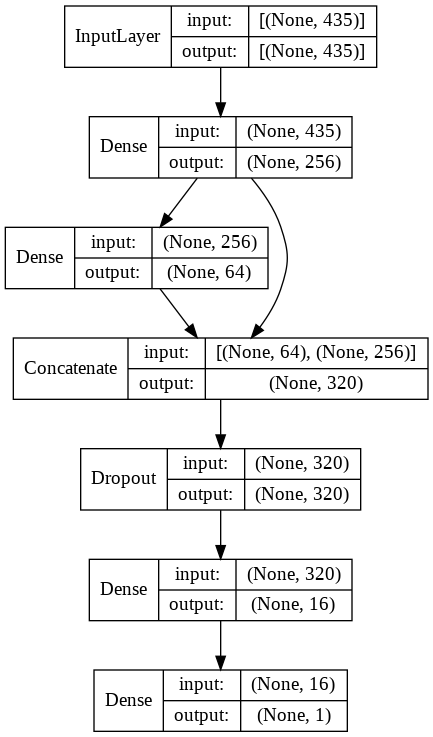

In [12]:
plot_model(keras_model(), 
        show_layer_names = False,
        show_shapes = True)

### Cross - Validation 
I'll use a standar validation loop, in which we scale the data and train the model. Since the dataset is imbalance, we'll use a StratifiedKFold because of it. <br>

And while training the neural networks with Stochastic or Mini Batch Gradient Descent and a constant learning rate, the algorithm usually converges towards minima in a noisy manner and ended up oscillating far away from actual minima. To overcome this scenario, there's a proposal brought up by some researchers that the decayed learning rate over time will help the network converge to a local minimun and avoid oscillation. It starts training the network with a large learning rate, and gradually decaying it until local minima is secured.

The below first image shows that with a constant learning rate, after certain iterations, the steps towards the minima is getting really unclear and jump around a lot, the result is not actually converges. 

In the second figure that after applying the decaying learning rate(green line), we can see that the ending part of the learning rate is getting smaller and smaller, and ends up oscillating in a faster dropping direction around the minima and heads to it. 

In [13]:
# set up the parameters 
ONLY_FIRST_FOLD = False 
EPOCHS_EXPONENTIALDECAY = 100 
VERBOSE = 0 # set to 0 for less output, or to 2 for more output 
LR_END = 1e-5 # learning rate at the end of training 
CYCLES = 1 
EPOCHS = 200 # how to choose the epochs? 
DIAGRAMS = True 
USE_PLATEAU = False # set to True for early stopping, or to False for exponential learning rate decay 
BATCH_SIZE = 2048 

np.random.seed(1)
random.seed(1) 
tf.random.set_seed(1)

In [14]:
def exponential_decay(epoch): 
    """
    The helper function for the learning rate's exponentially decay.
    -------------------
    v decays from e^a to 1 in every cycle
    w decays from 1 to 0 in every cycle
    epoch == 0                  -> w = 1 (first epoch of cycle)
    epoch == epochs_per_cycle-1 -> w = 0 (last epoch of cycle)
    higher a                    -> decay starts with a steeper decline
    """
    a = 3
    epochs_per_cycle = EPOCHS // CYCLES
    epoch_in_cycle = epoch % epochs_per_cycle
    if epochs_per_cycle > 1:
        v = math.exp(a * (1 - epoch_in_cycle / (epochs_per_cycle-1)))
        w = (v - 1) / (math.exp(a) - 1)
    else:
        w = 1
    return w * LR_START + (1 - w) * LR_END    


In [15]:
# From https://www.kaggle.com/code/inversion/amex-competition-metric-python
def amex_metric(y_true, y_pred, return_components=False) -> float:
    """Amex metric for ndarrays"""
    def top_four_percent_captured(df) -> float:
        """Corresponds to the recall for a threshold of 4 %"""
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

In [26]:
def fit_model(X_tr, y_tr, X_va=None, y_va=None, fold=0, run=0):
    """Scale the data, fit a model, plot the training history and optionally validate the model
    
    Saves a trained instance of tensorflow.keras.models.Model.
    
    As a side effect, updates y_va_pred, history_list, y_pred_list and score_list.
    """
    global y_va_pred
    gc.collect()
    start_time = datetime.datetime.now()
    
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    
    if X_va is not None:
        X_va = scaler.transform(X_va)
        validation_data = (X_va, y_va)
    else:
        validation_data = None
    # Define the learning rate schedule and EarlyStopping
    if USE_PLATEAU and X_va is not None: # use early stopping
        epochs = EPOCHS
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, 
                               patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                           patience=12, 
                           verbose=1,
                           mode="min", 
                           restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    else: # use exponential learning rate decay rather than early stopping
        epochs = EPOCHS_EXPONENTIALDECAY

        def exponential_decay(epoch):
            # v decays from e^a to 1 in every cycle
            # w decays from 1 to 0 in every cycle
            # epoch == 0                  -> w = 1 (first epoch of cycle)
            # epoch == epochs_per_cycle-1 -> w = 0 (last epoch of cycle)
            # higher a -> decay starts with a steeper decline
            a = 3
            epochs_per_cycle = epochs // CYCLES
            epoch_in_cycle = epoch % epochs_per_cycle
            if epochs_per_cycle > 1:
                v = math.exp(a * (1 - epoch_in_cycle / (epochs_per_cycle-1)))
                w = (v - 1) / (math.exp(a) - 1)
            else:
                w = 1
            return w * LR_START + (1 - w) * LR_END

        lr = LearningRateScheduler(exponential_decay, verbose=0)
        callbacks = [lr, tf.keras.callbacks.TerminateOnNaN()]
        
    # Construct and compile the model
    model = keras_model(X_tr.shape[1])
    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=validation_data, 
                        epochs=epochs,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    del X_tr, y_tr
    with open(f"scaler_{fold}.pickle", 'wb') as f: pickle.dump(scaler, f)
    model.save(f"model_{fold}")
    history_list.append(history.history)
    callbacks, es, lr, history = None, None, None, None
    
    if X_va is None:
        print(f"Training loss: {history_list[-1]['loss'][-1]:.4f}")
    else:
        lastloss = f"Training loss: {history_list[-1]['loss'][-1]:.4f} | Val loss: {history_list[-1]['val_loss'][-1]:.4f}"
        
        # Inference for validation
        y_va_pred = model.predict(X_va, batch_size=len(X_va), verbose=0).ravel()
        
        # Evaluation: Execution time, loss and metrics
        score = amex_metric(y_va, y_va_pred)
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {run}.{fold} | {str(datetime.datetime.now() - start_time)[-12:-7]}"
              f" | {len(history_list[-1]['loss']):3} ep"
              f" | {lastloss} | Score: {score:.5f}{Style.RESET_ALL}")
        score_list.append(score)
        
        if DIAGRAMS and fold == 0 and run == 0:
            # Plot training history
            plot_history(history_list[-1], 
                         title=f"Learning curve",
                         plot_lr=True)

            # Plot prediction histogram
            plt.figure(figsize=(16, 5))
            plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.xlabel('y_pred')
            plt.ylabel('density')
            plt.title('OOF Prediction Histogram')
            plt.show()

        # Scale and predict
        y_pred_list.append(model.predict(scaler.transform(test), batch_size=128*1024, verbose=0).ravel())
        with np.printoptions(linewidth=150, precision=2, suppress=True):
            print(f"Test pred {fold}", y_pred_list[-1])

435 features
Fold 0.0 | 01:31 | 100 ep | Training loss: 0.2197 | Val loss: 0.2278 | Score: 0.78481


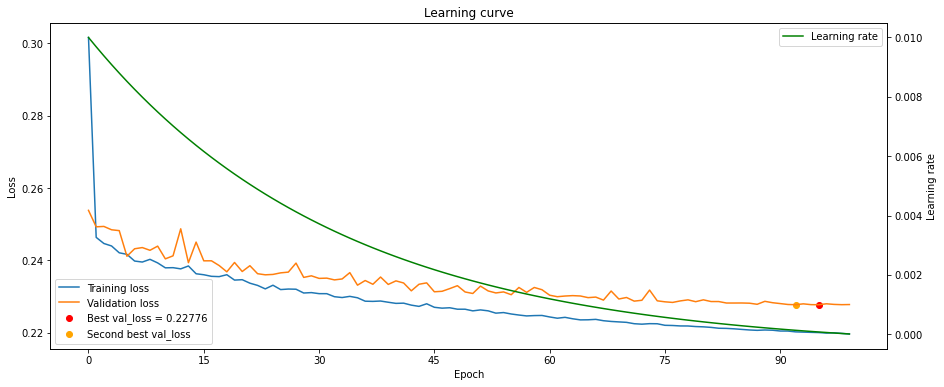

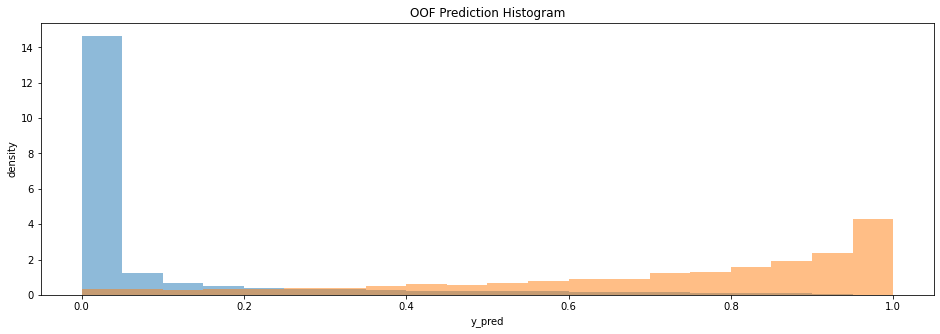

Test pred 0 [0.02 0.   0.03 ... 0.63 0.35 0.11]
Fold 0.1 | 01:28 | 100 ep | Training loss: 0.2199 | Val loss: 0.2255 | Score: 0.79075
Test pred 1 [0.03 0.   0.03 ... 0.63 0.32 0.18]
Fold 0.2 | 01:27 | 100 ep | Training loss: 0.2185 | Val loss: 0.2281 | Score: 0.78609
Test pred 2 [0.03 0.   0.02 ... 0.64 0.34 0.17]
Fold 0.3 | 01:26 | 100 ep | Training loss: 0.2183 | Val loss: 0.2260 | Score: 0.78697
Test pred 3 [0.03 0.   0.03 ... 0.68 0.33 0.11]
Fold 0.4 | 01:27 | 100 ep | Training loss: 0.2190 | Val loss: 0.2234 | Score: 0.79144
Test pred 4 [0.04 0.   0.03 ... 0.65 0.34 0.18]
Fold 0.5 | 01:27 | 100 ep | Training loss: 0.2194 | Val loss: 0.2242 | Score: 0.78526
Test pred 5 [0.02 0.   0.03 ... 0.61 0.34 0.1 ]
Fold 0.6 | 01:26 | 100 ep | Training loss: 0.2199 | Val loss: 0.2235 | Score: 0.78955
Test pred 6 [0.04 0.   0.02 ... 0.49 0.3  0.07]
Fold 0.7 | 01:27 | 100 ep | Training loss: 0.2202 | Val loss: 0.2213 | Score: 0.79070
Test pred 7 [0.03 0.   0.03 ... 0.63 0.33 0.08]
Fold 0.8 | 01:

In [27]:
print(f"{len(features)} features")
history_list = []
score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    y_va = target[idx_va]
    tf.keras.backend.clear_session()
    gc.collect()
    fit_model(train.iloc[idx_tr][features], target[idx_tr], 
              train.iloc[idx_va][features], y_va, fold=fold)
    if ONLY_FIRST_FOLD: break # we only need the first fold

print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score: {np.mean(score_list):.5f}{Style.RESET_ALL}")

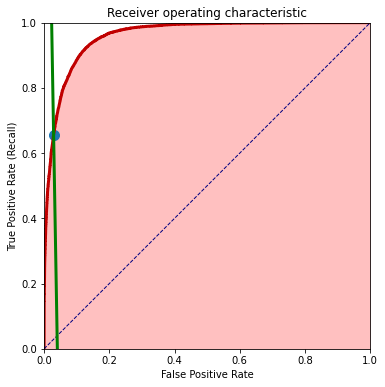

Area under the curve (AUC):         0.96077
2*AUC-1:                            0.92154
Normalized Gini coefficient:        0.92154 (same as 2*AUC-1)

Positive samples in validation set:   11883
Negative samples weighted:           680160 (unweighted: 34008)
Total samples weighted:              692043
4 % of Total samples weighted:        27681
True positives at this threshold:      7802
False positives at this threshold:    19880
Default rate captured at 4%:        0.65648 (= 7802 / 11883)

Competition score:                  0.78901 (= (0.92154 + 0.65648) / 2)


In [28]:
g, d, amex = amex_metric(y_va, y_va_pred, return_components=True)
total_positive = (y_va == 1).sum()
total_negative = (y_va == 0).sum() * 20
fourpercent = int(0.04 * (total_positive + total_negative))

plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_va, y_va_pred)
plt.plot(fpr, tpr, color='#c00000', lw=3) # curve
plt.fill_between(fpr, tpr, color='#ffc0c0') # area under the curve
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--") # diagonal
plt.plot([fourpercent / total_negative, 0], [0, fourpercent / total_positive],
         color="green", lw=3, linestyle="-") # four percent line
four_percent_index = np.argmax((fpr * total_negative + tpr * total_positive >= fourpercent))
plt.scatter([fpr[four_percent_index]],
            [tpr[four_percent_index]], 
            s=100) # intersection of roc curve with four percent line
plt.gca().set_aspect('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver operating characteristic")
plt.show()

print(f"Area under the curve (AUC):         {roc_auc_score(y_va, y_va_pred):.5f}")
print(f"2*AUC-1:                            {2 * roc_auc_score(y_va, y_va_pred) - 1:.5f}")
print(f"Normalized Gini coefficient:        {g:.5f} (same as 2*AUC-1)")
print()
print(f"Positive samples in validation set: {total_positive:7}")
#print(f"Negative samples in validation set: {total_negative // 20:7}")
print(f"Negative samples weighted:          {total_negative:7} (unweighted: {total_negative // 20})")
print(f"Total samples weighted:             {total_positive + total_negative:7}")
print(f"4 % of Total samples weighted:      {fourpercent:7}")
print(f"True positives at this threshold:   {int(tpr[four_percent_index] * total_positive):7}")
print(f"False positives at this threshold:  {int(fpr[four_percent_index] * total_negative):7}")
print(f"Default rate captured at 4%:        {d:7.5f} (= {int(tpr[four_percent_index] * total_positive)} / {total_positive})")
print()
print(f"Competition score:                  {amex:7.5f} (= ({g:7.5f} + {d:7.5f}) / 2)")

In [3]:
print("something")

something
